# Goals:
-	Build a model to predict the number of sales (Item_Outlet_Sales) using the available features.
-	Gain insights about the number of sales.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import category_encoders as ce
from sklearn.ensemble import  RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.preprocessing import Normalizer, StandardScaler, MinMaxScaler, PowerTransformer, MaxAbsScaler
from sklearn import linear_model
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline
%matplotlib inline

# Overview

In [2]:
# read the train data
data = pd.read_csv('Data\BigMart.csv')
# check for the null values
data.isna().sum()
# Drop row number 
data.drop("Unnamed: 0", axis = 1, inplace=True) 


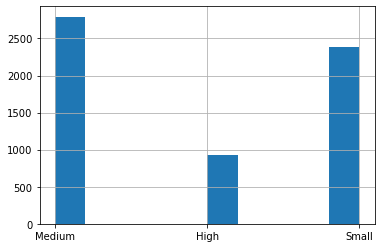

In [3]:
# data.Item_Weight.hist()
data.Outlet_Size.hist()

In [4]:
data.describe()
df_ = data.select_dtypes(exclude=['int', 'float'])
for col in df_.columns:
    print(df_[col].unique()) # to print categories name only
    # print(df_[col].value_counts()) # to print count of every category

['FDA15' 'DRC01' 'FDN15' ... 'NCF55' 'NCW30' 'NCW05']
['Low Fat' 'Regular' 'low fat' 'LF' 'reg']
['Dairy' 'Soft Drinks' 'Meat' 'Fruits and Vegetables' 'Household'
 'Baking Goods' 'Snack Foods' 'Frozen Foods' 'Breakfast'
 'Health and Hygiene' 'Hard Drinks' 'Canned' 'Breads' 'Starchy Foods'
 'Others' 'Seafood']
['OUT049' 'OUT018' 'OUT010' 'OUT013' 'OUT027' 'OUT045' 'OUT017' 'OUT046'
 'OUT035' 'OUT019']
['Medium' nan 'High' 'Small']
['Supermarket Type1' 'Supermarket Type2' 'Grocery Store'
 'Supermarket Type3']


## Data clean

In [5]:
# Fix some irregular values 
data.loc[data['Item_Fat_Content'].isin(['LF','low fat']), 'Item_Fat_Content'] = 'Low Fat'
data.loc[data['Item_Fat_Content'].isin(['reg']), 'Item_Fat_Content'] = 'Regular'

In [6]:
# impute NAs by mean
data.Item_Weight.fillna(data.Item_Weight.mean(),inplace=True)
# during EDA in R, discovered NAs present in Grocery and Supermarket type 1. 
# assume Grocery store are small and use mode for Type1 supermarket 

data.loc[:, ['Outlet_Type', 'Outlet_Size']].drop_duplicates()
data.loc[data['Outlet_Type'].eq('Grocery Store') & data['Outlet_Size'].isna(), 'Outlet_Size'] = 'Small'
data.Outlet_Size.mode()
data.loc[data['Outlet_Type'].eq('Supermarket Type1') & data['Outlet_Size'].isna(), 'Outlet_Size'] = 'Medium'
data.loc[:, ['Outlet_Type', 'Outlet_Size']].drop_duplicates()
data.loc[:, ['Item_Type']].drop_duplicates()
data.Outlet_Location_Type = data.Outlet_Location_Type.astype('str')
# save it 
data.to_csv("Data/cleaned.csv", index=False)


In [7]:
data = pd.read_csv('Data/cleaned.csv')

## Data preProcessing 

### Code categorical variables 

In [8]:
# create an object of the OneHotEncoder
Encoder = ce.OneHotEncoder(cols=['Item_Fat_Content',
                                 'Item_Type',
                                 'Outlet_Identifier',
                                 'Outlet_Size',
                                 'Outlet_Location_Type',
                                 'Outlet_Type'],
                                 use_cat_names=True)
# encode the categorical variables
data = Encoder.fit_transform(data)

In [9]:
# general information about the data
data.isna().sum()
data.describe()
data



,Item_Identifier,Item_Weight,Item_Fat_Content_Low Fat,Item_Fat_Content_Regular,Item_Visibility,Item_Type_Dairy,Item_Type_Soft Drinks,Item_Type_Meat,Item_Type_Fruits and Vegetables,Item_Type_Household,...,Outlet_Size_Small,Outlet_Size_High,Outlet_Location_Type_1.0,Outlet_Location_Type_3.0,Outlet_Location_Type_2.0,Outlet_Type_Supermarket Type1,Outlet_Type_Supermarket Type2,Outlet_Type_Grocery Store,Outlet_Type_Supermarket Type3,Item_Outlet_Sales
0,FDA15,9.300,1,0,0.016047,1,0,0,0,0,...,0,0,1,0,0,1,0,0,0,3735.1380
1,DRC01,5.920,0,1,0.019278,0,1,0,0,0,...,0,0,0,1,0,0,1,0,0,443.4228
2,FDN15,17.500,1,0,0.016760,0,0,1,0,0,...,0,0,1,0,0,1,0,0,0,2097.2700
3,FDX07,19.200,0,1,0.000000,0,0,0,1,0,...,1,0,0,1,0,0,0,1,0,732.3800
4,NCD19,8.930,1,0,0.000000,0,0,0,0,1,...,0,1,0,1,0,1,0,0,0,994.7052
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8518,FDF22,6.865,1,0,0.056783,0,0,0,0,0,...,0,1,0,1,0,1,0,0,0,2778.3834
8519,FDS36,8.380,0,1,0.046982,0,0,0,0,0,...,0,0,0,0,1,1,0,0,0,549.2850
8520,NCJ29,10.600,1,0,0.035186,0,0,0,0,0,...,1,0,0,0,1,1,0,0,0,1193.1136
8521,FDN46,7.210,0,1,0.145221,0,0,0,0,0,...,0,0,0,1,0,0,1,0,0,1845.5976


### Standarise numeric variables 

In [10]:
# create the StandardScaler 
scaler = StandardScaler()
# fit the Item_MRP and Weigh, and visibility 
num_cols = ['Item_Weight','Item_Visibility','Item_MRP']
# fit the Item_MRP and Weight and visibility
data[num_cols] = scaler.fit_transform(data[num_cols])


### Split data to train and test 

In [11]:
# separate the predictors and target variable 
train_X = data.drop(columns=['Item_Identifier','Item_Outlet_Sales'])
train_Y = data['Item_Outlet_Sales']

# randomly split the data
train_x, test_x, train_y, test_y = train_test_split(train_X, train_Y,test_size=0.2,random_state=0)

# shape of train and test splits
train_x.shape, test_x.shape, train_y.shape, test_y.shape, train_X.shape

((6818, 42), (1705, 42), (6818,), (1705,), (8523, 42))

## Baseline model

RMSE on train data:  1268501.1273168284
RMSE on test data:  1281083.8531990782
MAE on train data:  831.8945961956186
MAE on test data:  852.5904245329575
r2_score on train data:  0.5637902413353284
r2_score on test data:  0.5623008641722387


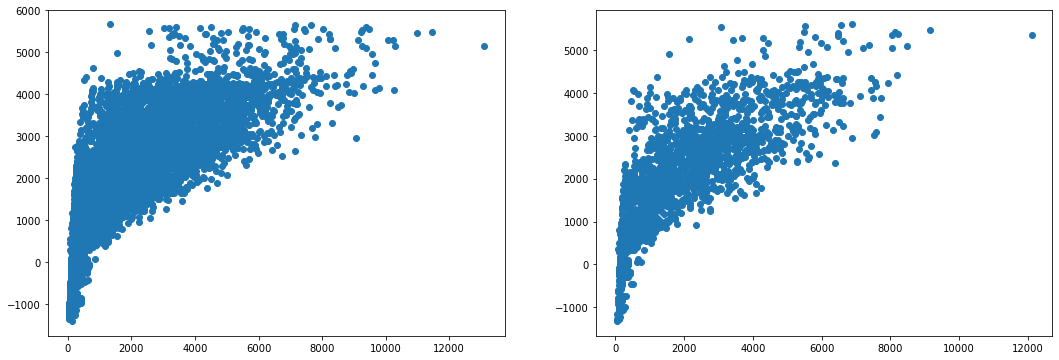

In [12]:
# create an object of the LinearRegression Model
model_LR = linear_model.LinearRegression(fit_intercept=False)

# fit the model with the training data
model_LR.fit(train_x, train_y)

# predict the target on train and test data 
predict_train = model_LR.predict(train_x)
predict_test  = model_LR.predict(test_x)

print('RMSE on train data: ', mean_squared_error(train_y, predict_train))
print('RMSE on test data: ',  mean_squared_error(test_y, predict_test))
print('MAE on train data: ', mean_absolute_error(train_y, predict_train))
print('MAE on test data: ',  mean_absolute_error(test_y, predict_test))
print('r2_score on train data: ', r2_score(train_y, predict_train))
print('r2_score on test data: ',  r2_score(test_y, predict_test))
plt.figure(figsize=(18,6))
plt.subplot(1, 2, 1)
plt.scatter(train_y,predict_train)
# plt.title( 'Link function ' + str(i) + '(Train data)')
plt.subplot(1, 2, 2)
plt.scatter(test_y,predict_test)
# plt.title( 'Link function ' + str(i) + '(Test data)')

In [13]:
## Extract feature coefs
d = {'featurename':model_LR.feature_names_in_, 
     'featurecoef':model_LR.coef_}
# coef = pd.Series(model_LR.coef_, model_LR.feature_names_in_, name = 'value').sort_values()

pd.DataFrame(d)


,featurename,featurecoef
0,Item_Weight,-6.887401e+00
1,Item_Fat_Content_Low Fat,1.624083e+12
2,Item_Fat_Content_Regular,1.624083e+12
3,Item_Visibility,-1.895833e+01
4,Item_Type_Dairy,1.820087e+08
5,Item_Type_Soft Drinks,1.820087e+08
6,Item_Type_Meat,1.820087e+08
7,Item_Type_Fruits and Vegetables,1.820088e+08
8,Item_Type_Household,1.820087e+08
9,Item_Type_Baking Goods,1.820088e+08


In [14]:
## Output evaluation results 
pd.DataFrame({'obs':test_y, 'pred':predict_test}).to_csv('Data/lmtestrs.csv', index = False)

### Try a random forest

In [15]:
# create an object of the RandomForestRegressor
model_RFR = RandomForestRegressor(max_depth=10)

# fit the model with the training data
model_RFR.fit(train_x, train_y)

# predict the target on train and test data
predict_train = model_RFR.predict(train_x)
predict_test = model_RFR.predict(test_x)

print('RMSE on train data: ', mean_squared_error(train_y, predict_train))
print('RMSE on test data: ',  mean_squared_error(test_y, predict_test))
print('MAE on train data: ', mean_absolute_error(train_y, predict_train))
print('MAE on test data: ',  mean_absolute_error(test_y, predict_test))
print('r2_score on train data: ', r2_score(train_y, predict_train))
print('r2_score on test data: ',  r2_score(test_y, predict_test))

RMSE on train data:  818508.3976953824
RMSE on test data:  1207762.731408464
MAE on train data:  634.6799426966129
MAE on test data:  781.2362832414467
r2_score on train data:  0.7185328866211302
r2_score on test data:  0.5873519890970696


# RF is better than LR so far. But overfitting 

# Try a lasso regression to drop some features?

In [16]:
from sklearn import linear_model
regressor = linear_model.Lasso(alpha=100,  
                               positive=True,
                               fit_intercept=False, 
                               max_iter=1000,
                               tol=0.0001)
regressor.fit(train_x, train_y)

Lasso(alpha=100, fit_intercept=False, positive=True)

In [17]:
import eli5
eli5.show_weights(regressor, top=-1, feature_names = train_x.columns.tolist())


Weight?,Feature
+869.526,Item_MRP
+719.257,Outlet_Identifier_OUT027
+231.660,Outlet_Size_Medium
+196.251,Outlet_Type_Supermarket Type1
+0.927,Outlet_Establishment_Year


In [18]:
df_L1=pd.DataFrame({'name': regressor.feature_names_in_,
              'coefs': regressor.coef_})
df_L1[df_L1['coefs' ]> 0 ].sort_values(by='coefs', ascending=False)


,name,coefs
20,Item_MRP,869.525974
25,Outlet_Identifier_OUT027,719.257085
32,Outlet_Size_Medium,231.659946
38,Outlet_Type_Supermarket Type1,196.251073
31,Outlet_Establishment_Year,0.926931


## Five features lead the way? 
Not sure if it's going to work

In [19]:
# Respilt the data
train_X = data.loc[:,df_L1[df_L1['coefs' ]> 0 ].name.tolist()]
train_Y = data['Item_Outlet_Sales']

# split the data
train_x, test_x, train_y, test_y = train_test_split(train_X, train_Y,test_size=0.2,random_state=0)

# shape of train and test splits
train_x.shape, test_x.shape, train_y.shape, test_y.shape

((6818, 5), (1705, 5), (6818,), (1705,))

In [20]:
# create the LinearRegression Model
model_LR = linear_model.LinearRegression()

# fit the model with the training data
model_LR.fit(train_x, train_y)

# predict the target on train and test data 
predict_train = model_LR.predict(train_x)
predict_test  = model_LR.predict(test_x)

# Root Mean Squared Error on train and test date
print('RMSE on train data: ', mean_squared_error(train_y, predict_train))
print('RMSE on test data: ',  mean_squared_error(test_y, predict_test))
print('MAE on train data: ', mean_absolute_error(train_y, predict_train))
print('MAE on test data: ',  mean_absolute_error(test_y, predict_test))
print('r2_score on train data: ', r2_score(train_y, predict_train))
print('r2_score on test data: ',  r2_score(test_y, predict_test))

RMSE on train data:  1360398.449408192
RMSE on test data:  1396387.872375763
MAE on train data:  873.373696711252
MAE on test data:  904.2393191926279
r2_score on train data:  0.5321887647357801
r2_score on test data:  0.5229057305710506


In [21]:
# create the RandomForestRegressor
model_RFR = RandomForestRegressor(max_depth=10)

# fit the model with the training data
model_RFR.fit(train_x, train_y)

# predict the target on train and test data
predict_train = model_RFR.predict(train_x)
predict_test = model_RFR.predict(test_x)

# Root Mean Squared Error on train and test data
print('RMSE on train data: ', mean_squared_error(train_y, predict_train)**(0.5))
print('RMSE on test data: ',  mean_squared_error(test_y, predict_test)**(0.5))
print('MAE on train data: ', mean_absolute_error(train_y, predict_train))
print('MAE on test data: ',  mean_absolute_error(test_y, predict_test))
print('r2_score on train data: ', r2_score(train_y, predict_train))
print('r2_score on test data: ',  r2_score(test_y, predict_test))

RMSE on train data:  913.3033133757522
RMSE on test data:  1125.178628612465
MAE on train data:  643.3609593223156
MAE on test data:  790.343852054082
r2_score on train data:  0.7131633867023452
r2_score on test data:  0.5674452543130843


### Not doing great
Need a pipleline and see more models


## Model selection 

### Prepara data 

In [22]:
# read the train data
data = pd.read_csv('Data/cleaned.csv')
Encoder = ce.OneHotEncoder(cols=['Item_Fat_Content',
                                 'Item_Type',
                                'Outlet_Identifier',
                                'Outlet_Size',
                                'Outlet_Location_Type',
                                'Outlet_Type'],use_cat_names=True)
# encode the categorical variables
data = Encoder.fit_transform(data)
num_cols = ['Item_Weight','Item_Visibility','Item_MRP']
scaler = StandardScaler()
# fit the Item_MRP and Weight
data[num_cols] = scaler.fit_transform(data[num_cols])

# define a fun to do col selections and split 
def split_traintest(df, dropvals, yvals = 'Item_Outlet_Sales'):

    # separate the predictors and target variable 
    X = df.drop(columns=dropvals)
    Y = data[yvals]

    # randomly split the data
    train_x, test_x, train_y, test_y = train_test_split(X, Y,test_size=0.2,random_state=42)
    return train_x, test_x, train_y, test_y

train_x, test_x, train_y, test_y = split_traintest(data, ['Item_Identifier','Item_Outlet_Sales'])
# check shape of train and test splits
print(train_x.shape, test_x.shape, train_y.shape, test_y.shape)

## Full x and y
X = data.drop(columns=['Item_Identifier','Item_Outlet_Sales'])
Y = data['Item_Outlet_Sales']


(6818, 42) (1705, 42) (6818,) (1705,)


### Try six with 10 fold 

In [23]:
# baselines
num_folds = 10
seed = 7

models = []
models.append(('LM', linear_model.LinearRegression()))
models.append(('L1', linear_model.Lasso()))
models.append(('L2', linear_model.Ridge()))
models.append(('BayesRidge',linear_model.BayesianRidge()))
models.append(('GLM',linear_model.TweedieRegressor(link='log',  max_iter=3000)))
models.append(('RF', RandomForestRegressor(max_depth=10, random_state=0)))
# build a pipeline
results = []
names = []
# copied from  https://www.kaggle.com/richarde/easy-pipeline-and-model-selection#2.0-Process-the-Data
for name, model in models:
    kfold = KFold(n_splits=num_folds)
    cv_results = cross_val_score(model, X, Y,  scoring = 'r2',cv=kfold)
    results.append(cv_results)
    names.append(name)
    msg = "%s %f %f " % (name, cv_results.mean(), cv_results.std())
    print(msg)

LM 0.558527 0.021378 
L1 0.559646 0.020985 
L2 0.558526 0.021295 
BayesRidge 0.558609 0.021226 


C:\anaconda\lib\site-packages\sklearn\linear_model\_glm\link.py:90: RuntimeWarning: overflow encountered in exp
  return np.exp(lin_pred)
C:\anaconda\lib\site-packages\sklearn\linear_model\_glm\link.py:93: RuntimeWarning: overflow encountered in exp
  return np.exp(lin_pred)
C:\anaconda\lib\site-packages\sklearn\_loss\glm_distribution.py:132: RuntimeWarning: overflow encountered in multiply
  return -2 * (y - y_pred) / self.unit_variance(y_pred)
C:\anaconda\lib\site-packages\sklearn\linear_model\_glm\glm.py:42: RuntimeWarning: overflow encountered in multiply
  temp = d1 * family.deviance_derivative(y, y_pred, weights)
C:\anaconda\lib\site-packages\sklearn\linear_model\_glm\glm.py:44: RuntimeWarning: invalid value encountered in matmul
  devp = np.concatenate(([temp.sum()], temp @ X))
C:\anaconda\lib\site-packages\sklearn\_loss\glm_distribution.py:316: RuntimeWarning: overflow encountered in square
  dev = (y - y_pred) ** 2


GLM 0.580277 0.028974 
RF 0.587207 0.030893 


### Visualisation 

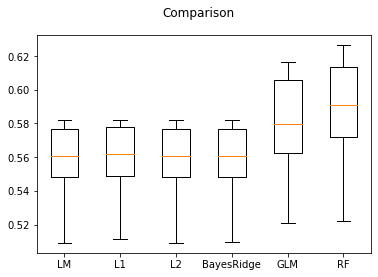

<Figure size 432x288 with 0 Axes>

In [24]:
# compare algorithms
fig = plt.figure()
fig.suptitle('Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()
plt.savefig('Reports/baselines.png', dpi = 300)

In [25]:
## save output for visualisation in R
rs_hold = [item for sublist in results for item in sublist]
df = pd.DataFrame({'names' :np.repeat(['LM','L1','L2','BayeL2', 'GLM', 'RF'], 10),
                   'r2':rs_hold})
## output 
df.to_csv('Data/baselines.csv')

## Hyperparameter tuning 

### GLM

r2_score on train data:  0.585784429693504
r2_score on test data:  0.5964148441847508


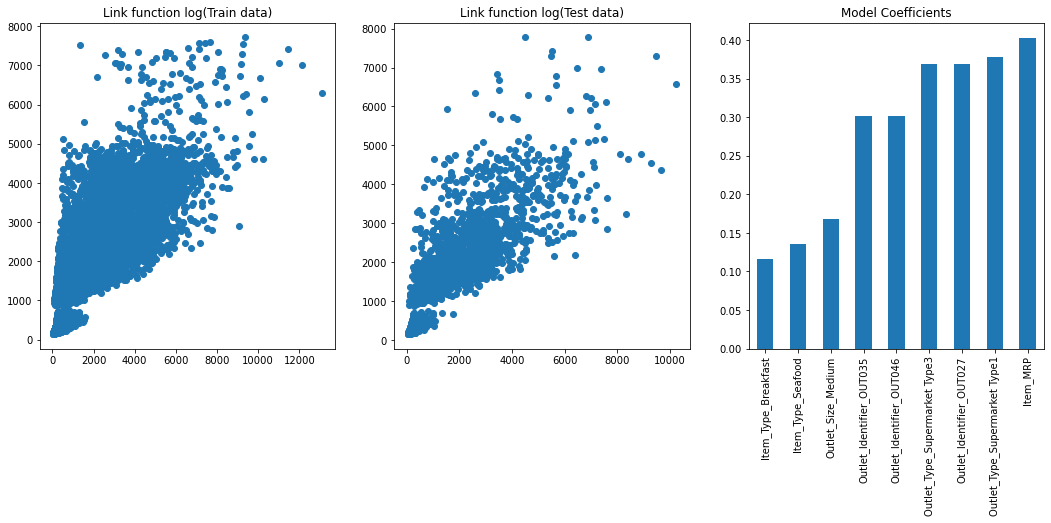

In [26]:
# create an object of the RandomForestRegressor
iterations = [5000]
links = ['log']
coefs = []
results = []
names = []
for i in links:
    model_glm = linear_model.TweedieRegressor( link=i,   max_iter=5000)
    # fit the model with the training data
    model_glm.fit(train_x, train_y)
    # predict the target on train and test data
    predict_train = model_glm.predict(train_x)
    predict_test = model_glm.predict(test_x)  
    # get the coef
    coef = pd.Series(model_glm.coef_, model_glm.feature_names_in_, name = 'value').sort_values()
    coefs.append(coef)    

    print('r2_score on train data: ', r2_score(train_y, predict_train))
    print('r2_score on test data: ',  r2_score(test_y, predict_test))    
    plt.figure(figsize=(18,6))
    plt.subplot(1, 3, 1)
    plt.scatter(train_y,predict_train)
    plt.title( 'Link function ' + str(i) + '(Train data)')
    plt.subplot(1, 3, 2)
    plt.scatter(test_y,predict_test)
    plt.title( 'Link function ' + str(i) + '(Test data)')
    plt.subplot(1, 3, 3)
    coef[coef>0.1].plot(kind='bar', title='Model Coefficients')
    
    plt.show()

## Save coefs 
pd.DataFrame(coefs).to_csv('Data/glm.csv', index = False)

### RF

In [27]:
# create an RandomForestRegressor
param_grid = {'bootstrap': [True],
              'max_depth': [5, 10, None], 
              'max_features': ['auto', 'log2'], 
              'n_estimators': [5, 6, 7, 8, 9, 10, 11, 12, 13, 15]
              }
              
g_search = GridSearchCV(estimator = RandomForestRegressor(), param_grid = param_grid, 
                        cv = 5, n_jobs = 1, verbose = 0,
                        return_train_score=True)
g_search.fit(train_x, train_y)
## save output 
df_grid = pd.concat([pd.DataFrame(g_search.cv_results_["params"]),
                     pd.DataFrame(g_search.cv_results_["mean_test_score"], 
                                  columns=["mean_test_score"]),
                     pd.DataFrame(g_search.cv_results_["rank_test_score"], 
                                  columns=["rank_test_score"])],axis=1)
df_grid.to_csv("Data/rf_gridsearch.csv", index=False)

In [28]:

model_rf = RandomForestRegressor( bootstrap=True, max_depth=5, max_features='auto', n_estimators=13, random_state=42) 
# fit the model with the training data
model_rf.fit(train_x, train_y)
# predict the target on train and test data
predict_train = model_rf.predict(train_x)
predict_test = model_rf.predict(test_x)  
# get the coef
# coef = pd.Series(model_rf.coef_, model_rf.feature_names_in_, name = 'value').sort_values()
# coefs.append(coef)

print('r2_score on train data: ', r2_score(train_y, predict_train))
print('r2_score on test data: ',  r2_score(test_y, predict_test))   

r2_score on train data:  0.6061230999997134
r2_score on test data:  0.6135636989932406


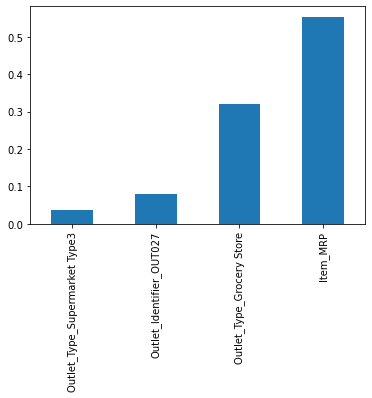

In [29]:
## best performer 
feature_impt = pd.Series(model_rf.feature_importances_, model_rf.feature_names_in_, name = 'value').sort_values()
feature_impt[feature_impt>0.01].plot(kind = 'bar')
## save output 
pd.DataFrame(feature_impt[feature_impt>0]).to_csv('Data/rf_featureimpt.csv')

## Plotting some useful figures 

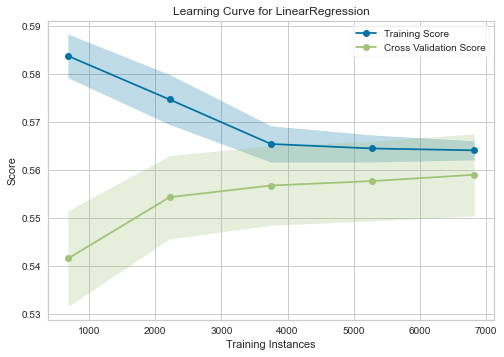

In [30]:
# separate the predictors and target variable 
train_X = data.drop(columns=['Item_Identifier','Item_Outlet_Sales'])
train_Y = data['Item_Outlet_Sales']

# randomly split the data
train_x, test_x, train_y, test_y = train_test_split(train_X, train_Y,test_size=0.2,random_state=0)

# shape of train and test splits
train_x.shape, test_x.shape, train_y.shape, test_y.shape


# Try plot a learning curve
from sklearn.linear_model import RidgeCV
from yellowbrick.model_selection import LearningCurve

# Instantiate the regression model and visualizer
model = linear_model.LinearRegression()
visualizer = LearningCurve(model, scoring='r2')

visualizer.fit(train_X, train_Y)        # Fit the data to the visualizer
visualizer.show('Reports/lmlearningcurve.png')           # Finalize and render the figure




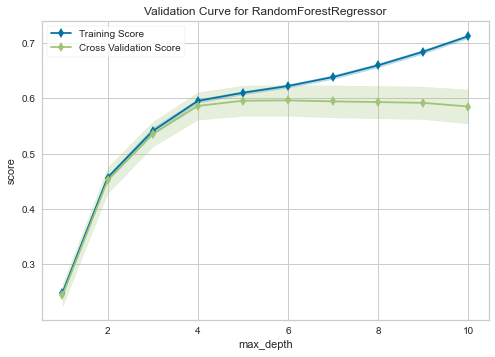

In [31]:
from yellowbrick.model_selection import ValidationCurve
viz = ValidationCurve(
    RandomForestRegressor(), param_name="max_depth",
    param_range=np.arange(1, 11), cv=10, scoring="r2"
)

# Fit and show the visualizer
viz.fit(train_X, train_Y)
viz.show(outpath='Reports/rf_maxdepth.png')

C:\anaconda\lib\site-packages\sklearn\linear_model\_glm\link.py:90: RuntimeWarning: overflow encountered in exp
  return np.exp(lin_pred)
C:\anaconda\lib\site-packages\sklearn\linear_model\_glm\link.py:93: RuntimeWarning: overflow encountered in exp
  return np.exp(lin_pred)
C:\anaconda\lib\site-packages\sklearn\linear_model\_glm\glm.py:42: RuntimeWarning: overflow encountered in multiply
  temp = d1 * family.deviance_derivative(y, y_pred, weights)
C:\anaconda\lib\site-packages\sklearn\linear_model\_glm\glm.py:44: RuntimeWarning: invalid value encountered in matmul
  devp = np.concatenate(([temp.sum()], temp @ X))
C:\anaconda\lib\site-packages\sklearn\_loss\glm_distribution.py:316: RuntimeWarning: overflow encountered in square
  dev = (y - y_pred) ** 2
C:\anaconda\lib\site-packages\sklearn\linear_model\_glm\link.py:90: RuntimeWarning: overflow encountered in exp
  return np.exp(lin_pred)
C:\anaconda\lib\site-packages\sklearn\linear_model\_glm\link.py:93: RuntimeWarning: overflow encou

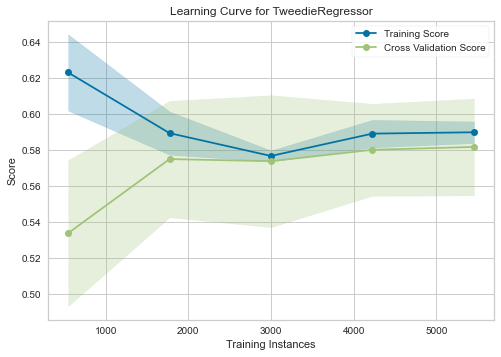

In [32]:

from yellowbrick.model_selection import LearningCurve

model = linear_model.TweedieRegressor(link='log',   max_iter=3000)
visualizer = LearningCurve(model, scoring='r2')

visualizer.fit(train_x, train_y)        # Fit the data to the visualizer
visualizer.show(outpath= 'Reports/glmLearningCurve.png')



In [33]:
# Compute train and test errors
from sklearn import linear_model
alphas = np.logspace(-5, 1, 10)
enet = linear_model.ElasticNet(l1_ratio=0.7, max_iter=10000)
train_errors = list()
test_errors = list()
for alpha in alphas:
    enet.set_params(alpha=alpha)
    enet.fit(train_x, train_y)
    train_errors.append(enet.score(train_x, train_y))
    test_errors.append(enet.score(test_x, test_y))

i_alpha_optim = np.argmax(test_errors)
alpha_optim = alphas[i_alpha_optim]
print("Optimal regularization parameter : %s" % alpha_optim)

# Estimate the coef_ on full data with optimal regularization parameter
enet.set_params(alpha=alpha_optim)
coef_ = enet.fit(train_x, train_y).coef_

C:\anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:645: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.322e+09, tolerance: 1.983e+06
  model = cd_fast.enet_coordinate_descent(
C:\anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:645: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.318e+09, tolerance: 1.983e+06
  model = cd_fast.enet_coordinate_descent(
C:\anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:645: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.042e+09, tolerance: 1.983e+06
  model = cd_fast.enet_coo

Optimal regularization parameter : 0.004641588833612777


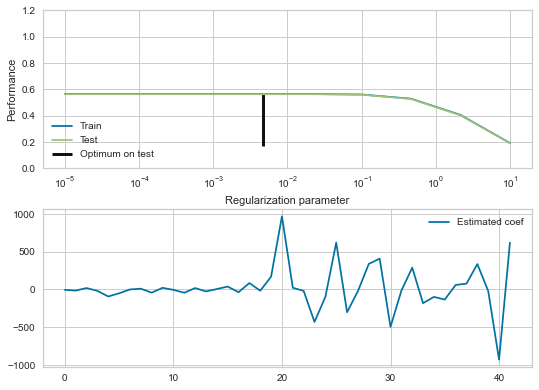

In [34]:
plt.subplot(2, 1, 1)
plt.semilogx(alphas, train_errors, label="Train")
plt.semilogx(alphas, test_errors, label="Test")
plt.vlines(
    alpha_optim,
    plt.ylim()[0],
    np.max(test_errors),
    color="k",
    linewidth=3,
    label="Optimum on test",
)
plt.legend(loc="lower left")
plt.ylim([0, 1.2])
plt.xlabel("Regularization parameter")
plt.ylabel("Performance")

# Show estimated coef_ vs true coef
plt.subplot(2, 1, 2)

plt.plot(coef_, label="Estimated coef")
plt.legend()
plt.subplots_adjust(0.09, 0.04, 0.94, 0.94, 0.26, 0.26)
plt.show()

In [35]:
# some feature enigeering change supermarket type 2 to 1

# data.loc[data['Item_Type'].isin(['Household', 'Health and Hygiene']), 'Item_Type'] = 'Noneedible'
# data.loc[data['Outlet_Type'].eq('Supermarket Type2'), 'Outlet_Type'] = 'Supermarket Type1'